# Current Testing Battery

In [2]:
import sys
import statistics
import numpy
from itertools import product
from timeit import default_timer as timer
from tqdm import tqdm
sys.path.append("..")
import gillespy2
from scipy import stats
import matplotlib.pyplot as plt

The performance of this package can be significantly increased if you install Cython.


In [3]:
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.ssa_c_solver import SSACSolver
from gillespy2.basic_root_solver import BasicRootSolver
from gillespy2.optimized_ssa_solver import OptimizedSSASolver
from gillespy2.basic_tau_leaping_solver import BasicTauLeapingSolver
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.example_models import *

In [4]:
import os
if 'STOCHKIT_HOME' not in os.environ:
    os.environ['STOCHKIT_HOME'] = "/mnt/c/Users/seanm/OneDrive/Documents/Research/StochKit"
print("STOCHKIT_HOME =",os.environ['STOCHKIT_HOME'])

STOCHKIT_HOME = /Users/bdrawert/Desktop/research/StochKit


In [5]:
def __get_results(solver, model, number_of_trajectories):
    results = []
    for i in tqdm(range(number_of_trajectories), desc='Model: {0}, Solver: {1}'.format(model.name, solver.name)):
        result = model.run(solver=solver)
        if isinstance(result, dict):
            results.append(result)
        else:
            results.append(result[0])
    return results

In [6]:
def create_distribution(solver, model, number_of_trajectories):
    results = __get_results(solver, model, number_of_trajectories)
    distribution = {}
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            distribution[species] = []
            for timestep in range(len(trajectory[species])):
                distribution[species].append([])
    trajectory_number = 0
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            for timestep in range(len(trajectory[species])):
                distribution[species][timestep].append(trajectory[species][timestep])
            
    return distribution    

In [7]:
def get_stats(solver, standard_results, model, number_of_trajectories):
    interior_stats = {}
    test_results = create_distribution(solver, model, number_of_trajectories)          
    for species in test_results:
        interior_stats[species] = []
    for species in test_results:
        for timestep, value in enumerate(test_results[species]):
            interior_stats[species].append(stats.ks_2samp(value, standard_results[species][timestep]))
    return interior_stats

In [9]:
standard_results = {}
ks_stats = {}

number_of_trajectories = 50

#solver_list = [BasicSSASolver(), BasicTauLeapingSolver(), BasicTauHybridSolver()]
solver_list = [OptimizedSSASolver(), BasicTauLeapingSolver(), BasicTauHybridSolver()]

model_list = [Example(), MichaelisMenten()]

for model in model_list:
    standard_results[model.name] = []
    ks_stats[model.name] = {}
    
for model in model_list:
    standard_results[model.name] = create_distribution(StochKitSolver, model, number_of_trajectories)
    for solver in solver_list:
        ks_stats[model.name][solver] = get_stats(solver, standard_results[model.name], model, number_of_trajectories)

Model: Michaelis_Menten, Solver: CythonSSASolver: 100%|██████████| 50/50 [00:01<00:00, 26.46it/s]
Model: Michaelis_Menten, Solver: Basic Tau Leaping Solver: 100%|██████████| 50/50 [00:07<00:00,  6.28it/s]
Model: Michaelis_Menten, Solver: Basic Tau Hybrid Solver: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


In [33]:
standard_results['Example'].keys()

dict_keys(['S'])

In [10]:
numpy_results = create_distribution(solver_list[0], model_list[0], number_of_trajectories)

Model: Example, Solver: CythonSSASolver: 100%|██████████| 50/50 [00:00<00:00, 755.77it/s]


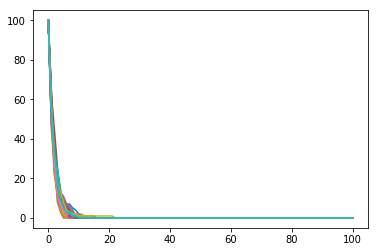

In [11]:
plt.plot(numpy_results['S'])

In [1]:
plt.plot(standard_results['Example']['S'])

NameError: name 'plt' is not defined

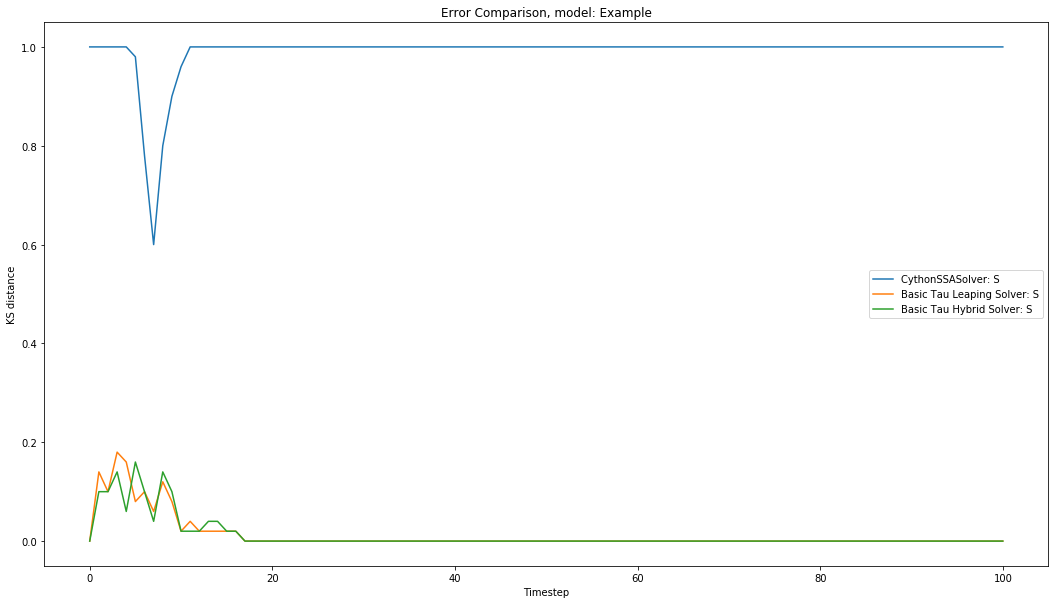

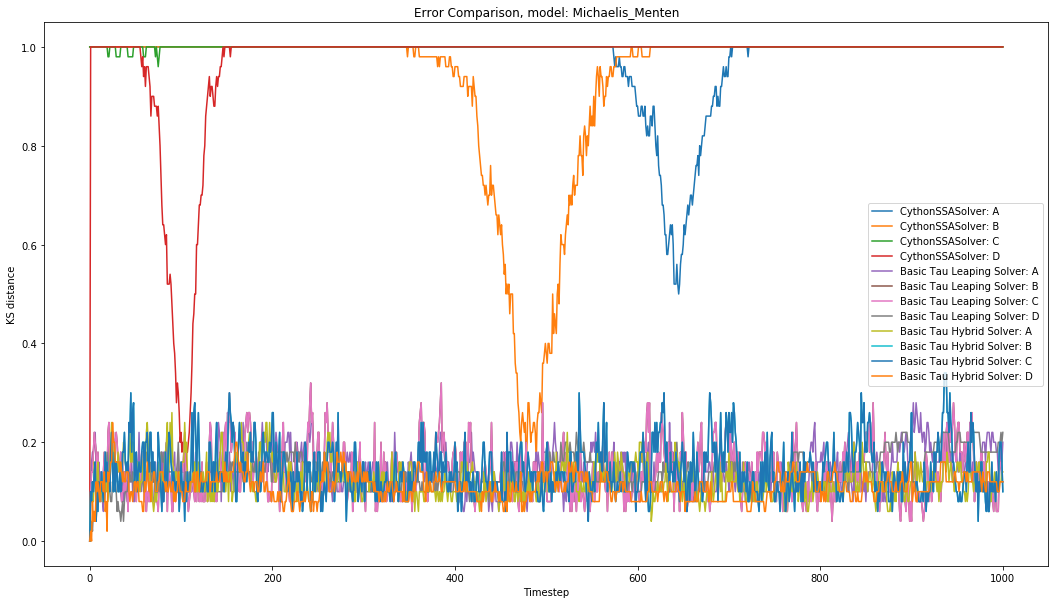

In [34]:
for i in range(len(model_list)):
    model_name = model_list[i].name

    plt.figure(figsize=(18,10))
    for solver in solver_list:
        plt.title("Error Comparison, model: " + model_name)
        plt.xlabel("Timestep")
        #plt.ylabel("P-Value")
        plt.ylabel("KS distance")
        for species in ks_stats[model_name][solver]:
            if species is not 'time':            

                result = ks_stats[model_name][solver][species][:]
                timesteps = []
                p_values = []
                for timestep, value in enumerate(result):
                    timesteps.append(timestep)
                    ks, pv = value
                    p_values.append(ks)
                plt.plot(timesteps, p_values, label='{0}: {1}'.format(solver.name, species))
    plt.legend(loc='best')
            
#             plt.plot(range(len(ks_stats[model_list[0].name][solver][species])), ks_stats[model_list[0].name][solver][species][:], label=solver.name)
# plt.legend(loc='best')
# for solver in solver_list:
#     print('Using Solver: ', solver.name)
#     for species in ks_stats[model_list[0].name][solver]:
#         if species is not 'time':
#             print('Species: ', species)
#             for timestep, timestep_result in enumerate(ks_stats[model_list[0].name][solver][species]):
#                 print('Timestep ', timestep, ': P-Value: ', timestep_result[1])
#                 plt.plot(timestep, timestep_result[1], label=species)
    

# 1) GET BASIC ODE SOLVER WORKING
# 2) COMPLETE TESTING
# 3)